# Import Libraries

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical

from art.attacks.evasion import FrameSaliencyAttack, FastGradientMethod
from art.estimators.classification import TensorFlowV2Classifier

# Load Data

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [3]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [4]:
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Model

In [5]:
model = Sequential([
    Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=(32, 32, 3)),
    Conv2D(32, (3, 3), activation="relu", padding="same"),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, (3, 3), activation="relu", padding="same"),
    Conv2D(64, (3, 3), activation="relu", padding="same"),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    
    Dense(512, activation="relu"),
    Dense(10)
])

In [6]:
model.compile(optimizer='adam', loss=CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# Train 

In [7]:
history = model.fit(x_train, y_train, batch_size=128, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
391/391 [==============================] - 7s 12ms/step - loss: 1.4003 - accuracy: 0.4975 - val_loss: 1.0796 - val_accuracy: 0.6164
Epoch 2/10
391/391 [==============================] - 4s 10ms/step - loss: 0.9590 - accuracy: 0.6627 - val_loss: 0.8843 - val_accuracy: 0.6869
Epoch 3/10
391/391 [==============================] - 4s 10ms/step - loss: 0.7565 - accuracy: 0.7338 - val_loss: 0.7814 - val_accuracy: 0.7264
Epoch 4/10
391/391 [==============================] - 4s 10ms/step - loss: 0.6031 - accuracy: 0.7885 - val_loss: 0.7599 - val_accuracy: 0.7453
Epoch 5/10
391/391 [==============================] - 4s 10ms/step - loss: 0.4716 - accuracy: 0.8358 - val_loss: 0.7139 - val_accuracy: 0.7615
Epoch 6/10
391/391 [==============================] - 4s 10ms/step - loss: 0.3338 - accuracy: 0.8855 - val_loss: 0.7899 - val_accuracy: 0.7590
Epoch 7/10
391/391 [==============================] - 4s 10ms/step - loss: 0.2182 - accuracy: 0.9244 - val_loss: 0.8358 - val_accuracy: 0.7600

In [8]:
classifier = TensorFlowV2Classifier(
    model=model,
    loss_object=CategoricalCrossentropy(from_logits=True),
    nb_classes=10,
    input_shape=(32, 32, 3),
)

# Attack

In [9]:
fgsm = FastGradientMethod(estimator=classifier, eps=0.4)

In [10]:
attack = FrameSaliencyAttack(classifier=classifier, attacker=fgsm)

In [11]:
adv_test = attack.generate(x_test[:100])

Frame saliency:   0%|          | 0/32 [00:00<?, ?it/s]

# Results

In [12]:
y_pred = model.predict(x_test[:100], verbose=0)

In [13]:
adv_pred = model.predict(adv_test, verbose=0)

In [14]:
y_pred = np.argmax(y_pred, axis=1)

In [15]:
adv_pred = np.argmax(adv_pred, axis=1)

In [16]:
y_test = np.argmax(y_test[:100], axis=1)

In [17]:
print("Original Accuracy Score:", np.sum(adv_pred == y_test) / len(y_test))
print("Adversarial Accuracy Score:", np.sum(y_pred == y_test) / len(y_test))

Original Accuracy Score: 0.12
Adversarial Accuracy Score: 0.76


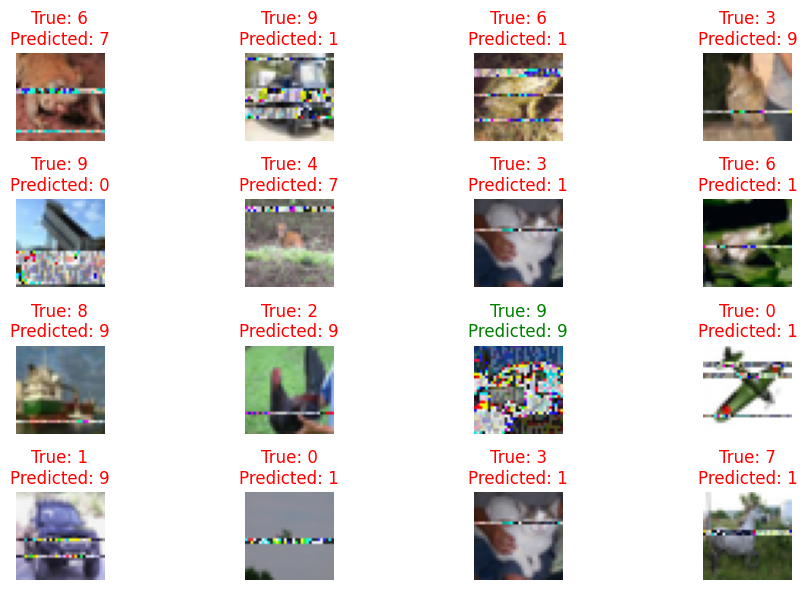

In [22]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 6))
random_index = np.random.randint(0, len(adv_test), 16)

for i, ax in enumerate(axes.ravel()):
    ax.imshow((adv_test[random_index[i]] * 255).astype(np.uint8))
    ax.axis('off')

    if y_test[random_index[i]] == adv_pred[random_index[i]]:
        color = 'green'
    else:
        color = 'red'

    ax.set_title(
        f'True: {y_test[random_index[i]]}\nPredicted: {adv_pred[random_index[i]]}',
        color=color
    )

plt.tight_layout()
plt.show()